In [2]:
!pip install openai==0.27.8 tqdm==4.65.0 -q

In [57]:
from dotenv import load_dotenv
import os
import numpy as np

In [2]:
import openai

In [3]:
load_dotenv("notebooks/.env")

False

In [4]:
load_dotenv(".env")

True

In [5]:
openai.api_key = os.environ['OPENAI_API_KEY']

## Load the dataset

In [6]:
import pandas as pd

In [7]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [8]:
tags = train_df.tag.unique().tolist()
tags

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [9]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm

In [10]:
def get_tag(model_name, system_content, user_content):
    try:
        response = openai.ChatCompletion.create(
            model=model_name,
            messages = [
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content}
            ]
        )
        prediction = response.to_dict()['choices'][0].to_dict()['message']['content']
        return prediction
    except:
        return None

In [11]:
model = "gpt-5-nano"
system_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."

In [12]:
tag = get_tag(model, system_context, user_context)

In [13]:
tag 

'natural-language-processing'

### make prediction on a list of datapoitns

In [14]:
samples = train_df[["title", "description"]].to_dict("records")[:3]
samples

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n'},
 {'title': 'Awesome Graph Classification',
  'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.'}]

In [15]:
def get_predictions(inputs, model_name, system_context):
    y_pred = []
    for item in tqdm(inputs, total=len(inputs)):
        user_context = str(item)
        predicted_tag = get_tag(model_name, system_context, user_context)
        while predicted_tag is None:
            time.sleep(10)
            predicted_tag = get_tag(model_name, system_context, user_context)
            
        y_pred.append(predicted_tag)
    return y_pred

In [16]:
get_predictions(samples, model, system_context)

100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


['computer-vision', 'computer-vision', 'other']

In [17]:
def clean_predictions(y_pred, tags=tags, default="other"):
    
    for i, item in enumerate(y_pred):
        if item not in tags:
            y_pred[i] = default
        elif item.startswith("'") and item.endswith("'"):
            y_pred[i] = item[1:-1]
    return y_pred

### Visualization

In [18]:
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

In [32]:
def evaluate(test_df, model, system_content, tags):
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    
    y_pred = get_predictions(
        test_samples, model, system_content
    )
    y_pred = clean_predictions(y_pred, tags)
    
    #metrics computation
    metrics = precision_recall_fscore_support(y_test, y_pred)
    performance = {"precision": list(metrics[0]), "recall": list(metrics[1]), "f1-score": list(metrics[2])}
    #print(performance)
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance

In [27]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

In [28]:
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

#### Zero shot performance

In [29]:
system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """

In [30]:
method = "zero_shot"
model = "gpt-5-nano"

  0%|          | 0/191 [00:00<?, ?it/s]

100%|██████████| 191/191 [05:06<00:00,  1.60s/it]


{'precision': array([0.98550725, 0.9375    , 1.        , 0.80645161]), 'recall': array([0.95774648, 0.9375    , 0.96153846, 0.96153846]), 'f1-score': array([0.97142857, 0.9375    , 0.98039216, 0.87719298])}


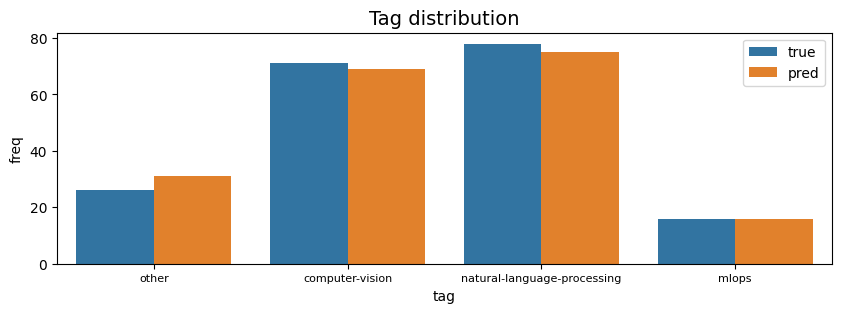

In [31]:
y_pred[method][model], performance[method][model] = evaluate(test_df, model, system_content, tags)

test on gpt-4o-mini

In [33]:
method = "zero_shot"
model = "gpt-4o-mini"

100%|██████████| 191/191 [01:12<00:00,  2.64it/s]


{
  "precision": [
    0.9830508474576272,
    0.75,
    0.9852941176470589,
    0.5909090909090909
  ],
  "recall": [
    0.8169014084507042,
    0.9375,
    0.8589743589743589,
    1.0
  ],
  "f1-score": [
    0.8923076923076924,
    0.8333333333333334,
    0.9178082191780821,
    0.7428571428571429
  ]
}


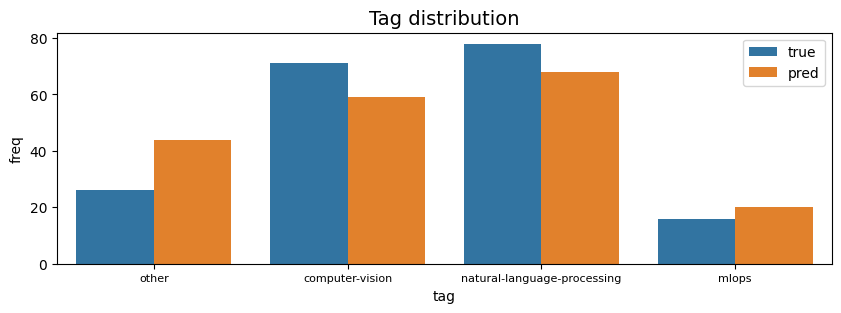

In [34]:
y_pred[method][model], performance[method][model] = evaluate(test_df, model, system_content, tags)

#### Few shot learning

In [35]:
num_samples = 2
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)
additional_context

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.',
  'tag': 'computer-vision'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n',
  'tag': 'computer-vision'},
 {'title': 'Awesome Graph Classification',
  'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.',
  'tag': 'other'},
 {'title': 'Awesome Monte Carlo Tree Search',
  'description': 'A curated list of Monte Carlo tree search papers with implementations. ',
  'tag': 'other'},
 {'title': 'Rethinking Batch Normalization in Transformers',
  'description': 'We found that NLP batch statistics exhibit large variance througho

In [36]:
system_content += f'''
                    Here are some examples with the correct labels: {additional_context}'''

In [37]:
method = "few_shot"
model = "gpt-5-nano"

100%|██████████| 191/191 [05:29<00:00,  1.72s/it]


{
  "precision": [
    0.9848484848484849,
    0.8235294117647058,
    1.0,
    0.7272727272727273
  ],
  "recall": [
    0.9154929577464789,
    0.875,
    0.9615384615384616,
    0.9230769230769231
  ],
  "f1-score": [
    0.948905109489051,
    0.8484848484848485,
    0.9803921568627451,
    0.8135593220338984
  ]
}


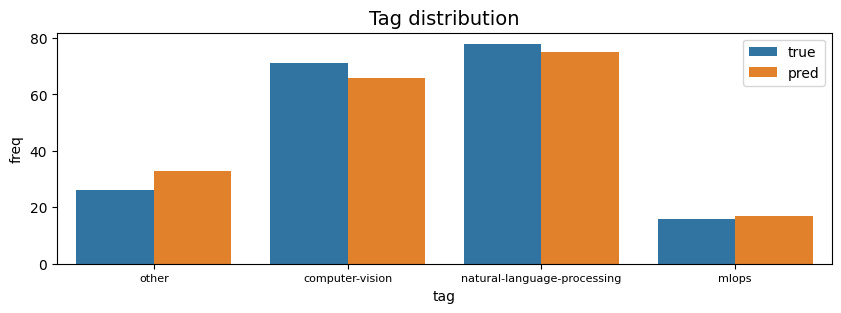

In [38]:
y_pred[method][model], performance[method][model] = evaluate(test_df, model, system_content, tags)

In [39]:
method = "few_shot"
model = "gpt-4o-mini"

100%|██████████| 191/191 [01:44<00:00,  1.83it/s]


{
  "precision": [
    0.9838709677419355,
    0.9333333333333333,
    1.0,
    0.5681818181818182
  ],
  "recall": [
    0.8591549295774648,
    0.875,
    0.8974358974358975,
    0.9615384615384616
  ],
  "f1-score": [
    0.9172932330827067,
    0.9032258064516129,
    0.945945945945946,
    0.7142857142857143
  ]
}


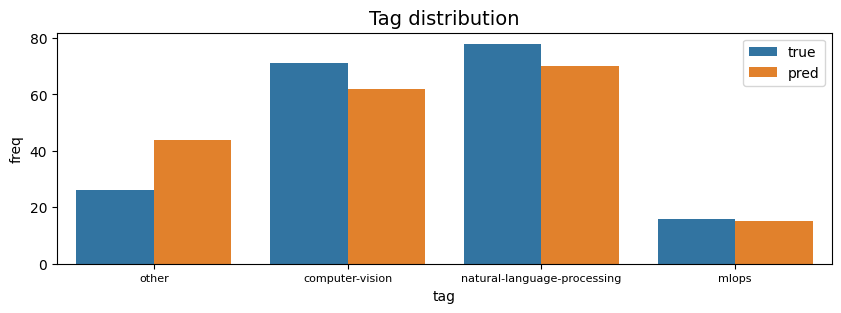

In [40]:
y_pred[method][model], performance[method][model] = evaluate(test_df, model, system_content, tags)

In [44]:
performance['zero_shot']['gpt-5-nano']['precision'] = list(performance['zero_shot']['gpt-5-nano']['precision'])
performance['zero_shot']['gpt-5-nano']['recall'] = list(performance['zero_shot']['gpt-5-nano']['recall'])
performance['zero_shot']['gpt-5-nano']['f1-score'] = list(performance['zero_shot']['gpt-5-nano']['f1-score'])

In [45]:
print(json.dumps(performance, indent=2))

{
  "zero_shot": {
    "gpt-5-nano": {
      "precision": [
        0.9855072463768116,
        0.9375,
        1.0,
        0.8064516129032258
      ],
      "recall": [
        0.9577464788732394,
        0.9375,
        0.9615384615384616,
        0.9615384615384616
      ],
      "f1-score": [
        0.9714285714285714,
        0.9375,
        0.9803921568627451,
        0.8771929824561403
      ]
    },
    "gpt-4o-mini": {
      "precision": [
        0.9830508474576272,
        0.75,
        0.9852941176470589,
        0.5909090909090909
      ],
      "recall": [
        0.8169014084507042,
        0.9375,
        0.8589743589743589,
        1.0
      ],
      "f1-score": [
        0.8923076923076924,
        0.8333333333333334,
        0.9178082191780821,
        0.7428571428571429
      ]
    }
  },
  "few_shot": {
    "gpt-5-nano": {
      "precision": [
        0.9848484848484849,
        0.8235294117647058,
        1.0,
        0.7272727272727273
      ],
      "recall": 

In [46]:
# Transform data into a new dictionary with four keys
by_model_and_context = {}
for context_type, models_data in performance.items():
    for model, metrics in models_data.items():
        key = f"{model}_{context_type}"
        by_model_and_context[key] = metrics

In [52]:
[pos + width * i for pos in x]

[0.0, 1.0, 2.0, 3.0]

In [63]:
np.average(metric_values, axis=1)

array([0.93236471, 0.82731351, 0.88391266, 0.87134653])

In [55]:
metrics

['precision', 'recall', 'f1-score']

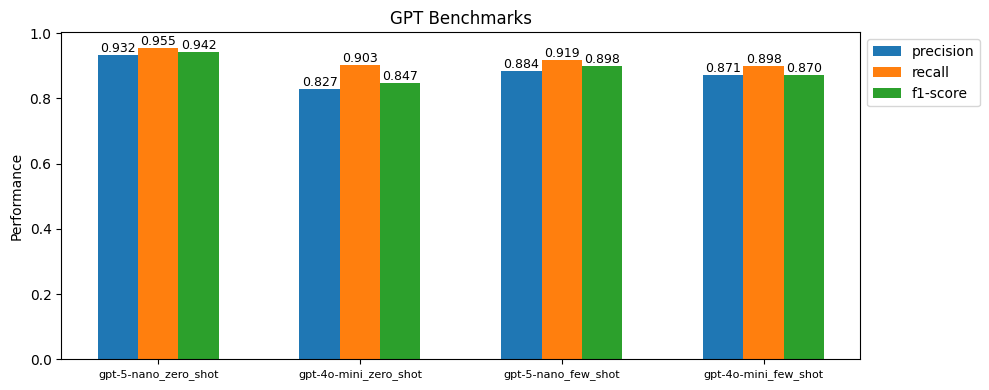

In [65]:
# Extracting the model names and the metric values
models = list(by_model_and_context.keys())
metrics = list(by_model_and_context[models[0]].keys())

# Plotting the bar chart with metric scores on top of each bar
fig, ax = plt.subplots(figsize=(10, 4))
width = 0.2
x = range(len(models))

for i, metric in enumerate(metrics):
    metric_values = [by_model_and_context[model][metric]
                     for model in models]
    metric_values = np.average(metric_values, axis=1)
    ax.bar([pos + width * i for pos in x], metric_values, width, label=metric)
    # Displaying the metric scores on top of each bar
    for pos, val in zip(x, metric_values):
        ax.text(pos + width * i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(models, rotation=0, ha='center', fontsize=8)
ax.set_ylabel('Performance')
ax.set_title('GPT Benchmarks')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()